In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances
from src.XAI.train_probes import get_hyperparams_combinations

/tmp/ipykernel_25353/1284858545.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Model doesn't matter, but train_probes creates data for each layer.
env_steps = Concept.load_concept_data()
model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)

Loaded model: 20240317-112025-10000000


In [4]:
hyperparam_ranges = {
    'lr': (0.00001,),
    'batch_size': (128,),
    'lambda_l1': (0.0,),
    'patience': (10,),
    'epochs': (200,)
}
hyperparams = get_hyperparams_combinations(hyperparam_ranges)

In [5]:
def plot_probe(concept, info):
    pd_info = pd.DataFrame(info)
    pd_info = pd_info.reset_index().rename(columns={'index': 'epoch'})
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Plot train and test loss
    axs[0].plot('epoch', 'train_eval', data=pd_info, label='Train Loss')
    axs[0].plot('epoch', 'test_eval', data=pd_info, label='Test Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Train and Test Loss')

    # Plot test score
    axs[1].plot('epoch', 'test_score', data=pd_info, label='Test Score', color='green')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Score')
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].set_title('Test Score')

    plt.tight_layout()
    plt.show()

Concept: good events quantity
binary: False
train: (8000, 84, 84, 3) (8000,)
test: (2000, 84, 84, 3) (2000,)
Train spape: torch.Size([8000, 64, 9, 9])
[{'lr': 1e-05, 'batch_size': 128, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200}]
good events quantity: 0.55


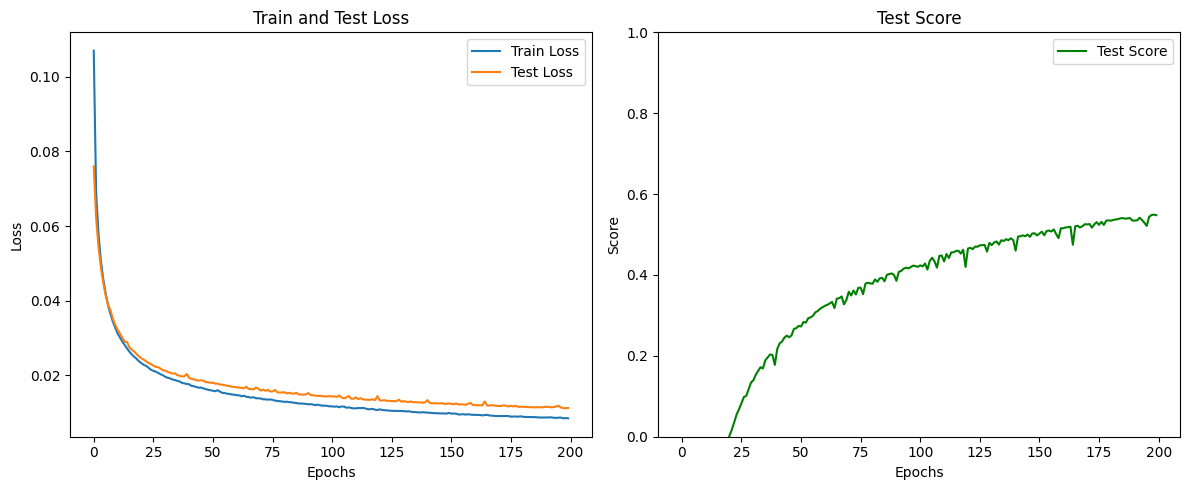

In [8]:
layer = 2 # -1 = input layer, independent of model
for concept in concept_instances.values():
    if concept.name != "good events quantity":
        continue
    concept.prepare_data(env_steps, max_size=10000)
    concept.summary()
    
    result = train_probes(model, concept, hyperparams, [layer])
    if len(result) == 3:
        layer_probes, layer_info, best_hyperparams = result
        print(best_hyperparams)
    else:
        layer_probes, layer_info = result
        
    score = layer_info[layer]['test_score'][-1]
    print(f'{concept.name}: {score:.2f}')
    plot_probe(concept, layer_info[layer])
        
    
    if layer == -1:
        probe = layer_probes[layer]
        coeffs = probe[1].weight.data.cpu().numpy()
        coeffs = coeffs.reshape(84, 84, 3)
        coeffs -= coeffs.min()
        coeffs /= coeffs.max()

        img = np.stack([coeffs[:, :, 0], coeffs[:, :, 1], coeffs[:, :, 2]], axis=2)
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'figures/input availability/{concept.name}.png')
        plt.show()

In [ ]:
layer = 2 # -1 = input layer, independent of model
for concept in concept_instances.values():
    if concept.name != "good events quantity":
        continue
    concept.prepare_data(env_steps, max_size=10000)
    concept.summary()
    
    result = train_probes(model, concept, hyperparams, [layer])
    if len(result) == 3:
        layer_probes, layer_info, best_hyperparams = result
        print(best_hyperparams)
    else:
        layer_probes, layer_info = result
        
    score = layer_info[layer]['test_score'][-1]
    print(f'{concept.name}: {score:.2f}')
    plot_probe(concept, layer_info[layer])
        
    
    if layer == -1:
        probe = layer_probes[layer]
        coeffs = probe[1].weight.data.cpu().numpy()
        coeffs = coeffs.reshape(84, 84, 3)
        coeffs -= coeffs.min()
        coeffs /= coeffs.max()

        img = np.stack([coeffs[:, :, 0], coeffs[:, :, 1], coeffs[:, :, 2]], axis=2)
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'figures/input availability/{concept.name}.png')
        plt.show()